## Composite CBFQP with numpy
With composite CBF, there is only one constraint and therefore a closed-form solution to QP is available.

#### References
- https://dev10110.github.io/tech-notes/maths/qp_closed_form.html
- https://arxiv.org/abs/2309.06647

In [1]:
import numpy as np
from scipy.special import logsumexp

def cbfqp(state:np.ndarray, nominal_control:np.ndarray, obstacle_positions:np.ndarray, distance_buffer:np.ndarray, alpha:float=1.0, kappa:float=10.0):
    """
    Args:
        state: numpy array of shape (2,) for XY position
        nominal_control: numpy array of shape (2,) for XY velocity
        obstacle_positions: numpy array of shape (n, 2) where n is the number of obstacles
        distance_buffer: numpy array of shape (n,) where n is the number of obstacles
        alpha: tuning parameter of the CBF, the larger the more conservatibr
        kappa: tuning parameter of the CBF, the larger the stronger of the soft-max effect over (-1 * obstacle distance)
    """
    if nominal_control.ndim == 1:
        nominal_control = nominal_control.reshape(-1, 1)

    # Define barrier function
    hi_x = -(distance_buffer**2) + (np.linalg.norm(state - obstacle_positions, axis=1) ** 2)
    h = -1 / kappa * logsumexp(-kappa * hi_x)  # compisite hi(x) to shape=()

    # Compute Lie derivatives
    composite_weights = np.exp(-kappa * (hi_x - h)).reshape(-1, 1)  # shape=(nh, 1) where nh is the number of obstacles
    Lfh = np.zeros((1,))  # Drift term effect
    Lgh_i = 2 * (state - obstacle_positions)  #  Control term effect
    Lgh = np.sum(composite_weights * Lgh_i, axis=0).reshape(1, -1)  # sum over obstacles, shape=(1, 2)

    # Closed-form CBFQP solution
    cbf_constr = (Lfh + Lgh @ nominal_control + alpha * h).squeeze()
    if cbf_constr >= 0:
        return nominal_control.squeeze()
    else:
        return (nominal_control - cbf_constr / (Lgh @ Lgh.T).squeeze() * Lgh.T).squeeze()

In [12]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import imageio

class OmniDirRobotSim:
    def __init__(self, world_width, world_height, robot_size, obstacles, lidar_resolution=360, lidar_range=10):
        self.world_width = world_width
        self.world_height = world_height
        self.robot_size = robot_size
        self.obstacles = obstacles
        self.lidar_resolution = lidar_resolution
        self.lidar_range = lidar_range
        self.position = np.array([0.0, 0.0])
        self.trajectory = []
        self.frames = []

    def move(self, vel_x, vel_y, dt=0.1):
        new_position = self.position + np.array([vel_x, vel_y]) * dt
        if 0 <= new_position[0] <= self.world_width and 0 <= new_position[1] <= self.world_height:
            self.position = new_position
        self.trajectory.append(tuple(self.position))

    def visualize(self, control_input, nominal_cointrol_input, save_frame=True):
        clear_output(wait=True)  # Clear previous output
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, self.world_width)
        ax.set_ylim(0, self.world_height)
        ax.set_aspect('equal')
        ax.grid(True, linestyle='--', alpha=0.5)

        for (ox, oy, oradius) in self.obstacles:
            obstacle = plt.Circle((ox, oy), oradius, color='red', alpha=0.5, label='Obstacle')
            ax.add_patch(obstacle)

        if self.trajectory:
            traj_x, traj_y = zip(*self.trajectory)
            ax.plot(traj_x, traj_y, 'b-', alpha=0.5, linewidth=1.5, label='Trajectory')

        robot_x, robot_y = self.position
        robot = plt.Circle((robot_x, robot_y), self.robot_size, color='blue', alpha=0.7, label='Robot')
        ax.add_patch(robot)

        vel_x, vel_y = nominal_cointrol_input
        ax.arrow(robot_x, robot_y, vel_x, vel_y, head_width=0.3, head_length=0.3, fc='r', ec='r', label='Nominal Control Input')

        vel_x, vel_y = control_input
        ax.arrow(robot_x, robot_y, vel_x, vel_y, head_width=0.3, head_length=0.3, fc='g', ec='g', label='Safe Control Input')

        ax.set_xlabel("X position")
        ax.set_ylabel("Y position")
        ax.set_title("Omni-Directional Robot Simulation")
        ax.legend()

        if save_frame:
            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer.buffer_rgba())
            self.frames.append(frame)

        display(fig)  # Show the updated figure
        plt.close(fig)  # Close to prevent duplicate display

    def save_gif(self, filename="robot_simulation.gif", fps=20):
        imageio.mimsave(filename, self.frames, fps=fps)



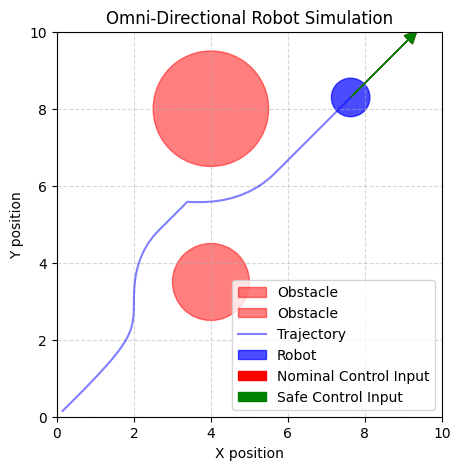

In [13]:
world_width, world_height = 10, 10
robot_size = 0.5
obstacles = [(4, 3.5, 1), (4, 8, 1.5)]
robot = OmniDirRobotSim(world_width, world_height, robot_size, obstacles)
nominal_cointrol = np.array([1.5, 1.5])

for _ in range(75):

    control_input = cbfqp(
        robot.position,
        nominal_cointrol,
        np.array(obstacles)[:, :2],
        distance_buffer=robot.robot_size*1.5 + np.array(obstacles)[:, -1],
        alpha=1.0,
        kappa=10.0
    )

    robot.move(*control_input)
    robot.visualize(control_input, nominal_cointrol)
robot.save_gif()  # save animation as robot_simulation.gif